In [4]:
import numpy as np
import pandas as pd

from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('preprocessed.csv')

n = 20000 #len(df) #179149

df_slice = df.iloc[:n, :]

products = len(df_slice.code.unique())

In [6]:
df_slice.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,sale_date,source_channel,sale_yearmon,sale_year,sale_month,sale_day,gross_margin,net_margin
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,2016-06-11,b76eb9b8fc0f17098812da9117d3e500,2016-06,2016,6,11,0.249619,0.353096
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,2016-06-11,b76eb9b8fc0f17098812da9117d3e500,2016-06,2016,6,11,0.476299,0.213799
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,2016-06-12,b76eb9b8fc0f17098812da9117d3e500,2016-06,2016,6,12,0.249619,0.353096
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,2016-06-13,b76eb9b8fc0f17098812da9117d3e500,2016-06,2016,6,13,0.445596,0.173096
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,2016-06-13,b76eb9b8fc0f17098812da9117d3e500,2016-06,2016,6,13,0.246925,0.351477


### Normalizando as variáveis numéricas

In [7]:
normalizable = ['quantity', 'price', 'pis_cofins', 'icms', 'tax_substitution', 'gross_margin', 'net_margin']
df_norm = df_slice.loc[:, normalizable]
df_norm = (df_norm - df_norm.mean()) / df_norm.std()

df_norm = df_norm.drop(['quantity'], axis = 1) # Removing quantity because it distorts the clustering and it's the variable to forecast

### Transformação de variáveis categóricas em dummies

In [8]:
non_normalizable = [c for c in df_slice.columns.tolist() if c not in normalizable]
df_clustering = df_slice.loc[:, non_normalizable]

categorical = ['code', 'category', 'source_channel', 'sale_year', 'sale_month', 'sale_day']
prefix = ['code', 'category', 'source_channel', 'sale_year', 'sale_month', 'sale_day']
df_clustering = pd.get_dummies(df_clustering, columns=categorical, prefix=categorical)

df_clustering = df_clustering.drop(['sale_yearmon', 'sale_date'], axis = 1)

In [9]:
df_clustering = pd.concat([df_clustering, df_norm], axis=1)
df_clustering.head()

,order_id,code_193628b6634713730d3c506f2da0ff58,code_29424aaf6e27a8dbe4b7273a0a39131d,code_2ab0e87dbce6ac45502aa1d2a8265933,code_32ceebf3efea1d04ace4183d20d4da5b,code_374e1947dcb8f4848f4ada6f04921edd,code_54209126056016c7c391c0c8fd8e6eff,code_5fb59bee157577ee04a269e52af88598,code_60424117a2618c7184687046fa5693c4,code_723f73c85e91fc31d147dfade389d4f9,...,sale_day_28,sale_day_29,sale_day_30,sale_day_31,price,pis_cofins,icms,tax_substitution,gross_margin,net_margin
0,bcb59c839e78b2601374cbad9239ca7b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.966524,4.957126,-0.959076,5.858899,-0.720297,1.054539
1,4e91ee6b95895771dc9ee524e910a902,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5.364558,5.354211,4.867540,-0.636959,0.853604,-0.100404
2,88eb0ac86af1a521c0831298d22dea8b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.966524,4.957126,-0.959076,5.858899,-0.720297,1.054539
3,dee418152a36314b4aee6ce9cf94fcbf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.966524,4.957126,4.868622,-0.636959,0.640424,-0.437884
4,1c175bc61b9b659bbf011b2e5e3dcec6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.946757,4.937401,-0.959076,5.875521,-0.739002,1.041118


In [10]:
Z = linkage(df_clustering.iloc[:, 1:], 'average')

In [11]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if kwargs.get('no_plot', True):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('points')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
    return ddata

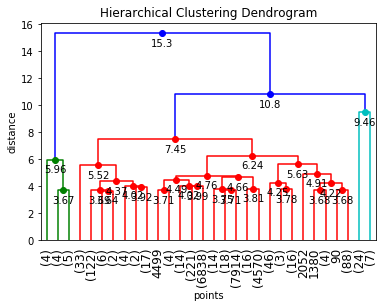

In [12]:
fancy_dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=12.,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=30,  # show only the last p merged clusters
)
plt.show()

### Usar o Coeficiente de Correlação Cofenética para comparar (correlacionar) os pares de distâncias de todas as amostras com aqueles inferidos pelo agrupamento hierarquizado (clustering). Quanto mais próximo de 1, melhor o agrupamento preservou as distâncias originais

In [13]:
c, coph_dists = cophenet(Z, pdist(df_clustering.iloc[:, 1:]))
c

0.89978268177283138

### Trazer os labels dos agrupamentos de volta para o dataframe

In [14]:
products = len(df_slice.code.unique())
products

14

In [15]:
df_slice['labels'] = fcluster(Z, products, criterion='maxclust')

/Users/raphaelrrcoelho/anaconda3/envs/luizalabs/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Analisando outliers

In [16]:
df_slice['sale_yearmon'].value_counts()

2017-01    2854
2017-05    2486
2016-10    2471
2017-03    2170
2016-11    1894
2016-09    1555
2016-08    1252
2017-04    1213
2016-12    1177
2016-07    1149
2017-02     883
2016-06     835
2017-06      61
Name: sale_yearmon, dtype: int64

In [17]:
outliers_clusters = df_slice['labels'].value_counts()
outliers_clusters = outliers_clusters[outliers_clusters == 1].index.tolist()
df_slice[df_slice['labels'].isin(outliers_clusters)]

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,sale_date,source_channel,sale_yearmon,sale_year,sale_month,sale_day,gross_margin,net_margin,labels
2052,04d80cf4804ea939da3d0ff2717b30b6,60424117a2618c7184687046fa5693c4,8,719.28,66.5334,0.0,17.1175,388128822cef4b4f102ae881e040a64b,2017-01-31,fc7020775a7cdf161ab5267985c54601,2017-01,2017,1,31,0.9061,0.837398,12


### Outliers com preços mais elevados e quantidades maiores

### Separar Mês 05 para Teste de Forecast

In [18]:
df_slice[df_slice['sale_yearmon'] < '2017-05'][['code', 'quantity', 'sale_date', 'labels']].to_csv('train_clustered.csv', index=False)

In [19]:
df_slice[df_slice['sale_yearmon'] >= '2017-05'][['code', 'quantity', 'sale_date', 'labels']].to_csv('test_clustered.csv', index=False)